# Example Workflow
Use this notebook as an example workflow when working with raw pressure history data and raw ILI mechanical caliper data.

In [14]:
import cycle_counting as cc
import md_profiles as mdp
import md_fatigue as mdf

import pandas as pd
import numpy as np
import os

## Step 0 - Load the Raw Data
### ILI Caliper Data
This assumes that you already have your ILI caliper data transformed into the **acceptable standardized format**, which is:
- Caliper channel orientation in `degrees` in the **column** direction (e.g., A, B, C) having `N` number of entries.
- Axial displacement in `inches` in the **row** direction (e.g., 1, 2, 3) having `M` number of entries.
- Radius values in `inches` being the absolute internal radius as the cells (e.g., B2, C2, B3, C3) having `N x M` number of entries.
- Generally, there should be more axial displacement entries than caliper channels (i.e., `M > N`).

An example of the data layout in a .csv file is shown in the table below:

|  | Caliper Orientation 1 | Caliper Orientation 2 | ... | Caliper Orientation N |
| :--- | :----: | :----: | :----: | :----: |
| Axial Displacement 1 | Radius (1,1) | Radius (1,2) | ... | Radius (1,N) |
| Axial Displacement 2 | Radius (2,1) | Radius (2,2) | ... | Radius (2,N) |
| ... | ... | ... | ... | ... |
| Axial Displacement M | Radius (M,1) | Radius (M,2) | ... | Radius (M,N) |

### Pressure History Data
Similarly, this assumes that your pressure history data has the following format:
- Absolute time in the first column (i.e., A) having `K` number of entries.
- Upstream (US) pressure history in `psig` in the second column, (i.e., B) having `K` number of entries.
- Downstream (DS) pressure history in `psig` in the third column (i.e., C) having `K` number of entries.
- All three columns **must** have the same number of entries.

An example of the data layout in a .csv file is shown in the table below:

| Time | US Pressure `psig` | DS Pressure `psig` | 
| :----: | :----: | :----: |
| Time 1 | US Pressure 1 | DS Pressure 1 | 
| Time 2 | US Pressure 2 | DS Pressure 2 | 
| ... | ... | ... | 
| Time K | US Pressure K | DS Pressure K | 

### Dent Metadata
Establish dent metadata that is provided in the pipe tally, such as pipe characteristics (e.g., OD, WT, SMYS) and dent location information (e.g., Lx, hx).

In [15]:
# Load your raw ILI caliper data into a DataFrame
dent_path = "tests/test_profile.csv"
df_dent = pd.read_csv(os.path.abspath(dent_path), index_col=0, dtype=float)
# Force the columns to be float type
df_dent.columns = df_dent.columns.astype(float)

In [16]:
# Load your raw pressure history data into a DataFrame
pressure_path = "tests/test_pressure_history.csv"
df_p = pd.read_csv(os.path.abspath(pressure_path), index_col=0, dtype={1: float, 2: float})

# Dent metadata
dd = {
    "OD" : 12.75,  # inches
    "WT" : 0.250,  # inches
    "SMYS" : 52000,  # psi
    "Lx" : 1000,  # length in feet at which dent is located
    "hx" : 30,  # height in feet at which dent is located
    "SG" : 0.8,  # product specific gravity
    "L1" : 500,  # length in feet of upstream segment
    "L2" : 1500,  # length in feet of downstream segment
    "h1" : 10,  # height in feet of upstream segment
    "h2" : 50,  # height in feet of downstream segment
    "D1" : 12.75,  # diameter in inches of upstream segment
    "D2" : 12.75,  # diameter in inches of downstream segment
}


## Step 1 - Generate MD-4-9 Profiles
Create a `DentProfiles` object using the `df_dent` DataFrame containing your raw ILI caliper data. Visit `md_profiles` to see the capabilities of the module, but some quick attributes and functions are:
- Print the object (i.e., `print(DentProfiles)`) to get a tabular summary of the key attributes, such as lengths and areas for each quadrant.
- Use the `.graph()` function to plot the axial and circumferential lengths.
- Use the `.min_idx` attribute to get the index of deepest location.
- Use the `.df` attribute to get the dent DataFrame.

In [17]:
# Generate a DentProfiles object
import importlib
importlib.reload(mdp)
dp = mdp.DentProfiles(df_dent, dd["OD"], dd["WT"])

In [18]:
# Show summary of the DentProfiles object
print(dp)

DentProfiles Summary:
 - OD: 12.75-inch, WT: 0.25-inch
 - Dent Depth based on overall radius of 17.544-inch: 0.889-inch (6.975 %OD)
 - Dent Location and Radius: (Axial = 76.06-inch, Circumferential = 103.5-deg, Radius = 16.65-inch)

Summary of Lengths and Areas by Quadrant (% levels as index):
   US-Lengths   US-Areas DS-Lengths  DS-Areas US-CCW-Lengths US-CCW-Areas US-CW-Lengths US-CW-Areas DS-CCW-Lengths DS-CCW-Areas DS-CW-Lengths DS-CW-Areas
95    1.20492              3.958011                                                                                                                      
90   2.134249              4.810975                 3.095484                   4.545159                   1.894615                   2.810596            
85   2.787988   1.816642   5.627205  2.213869       4.569454     4.976119      5.671654    2.899608       2.841923     2.610445      4.215894    1.716772
80                                                  5.319992                   6.798149  

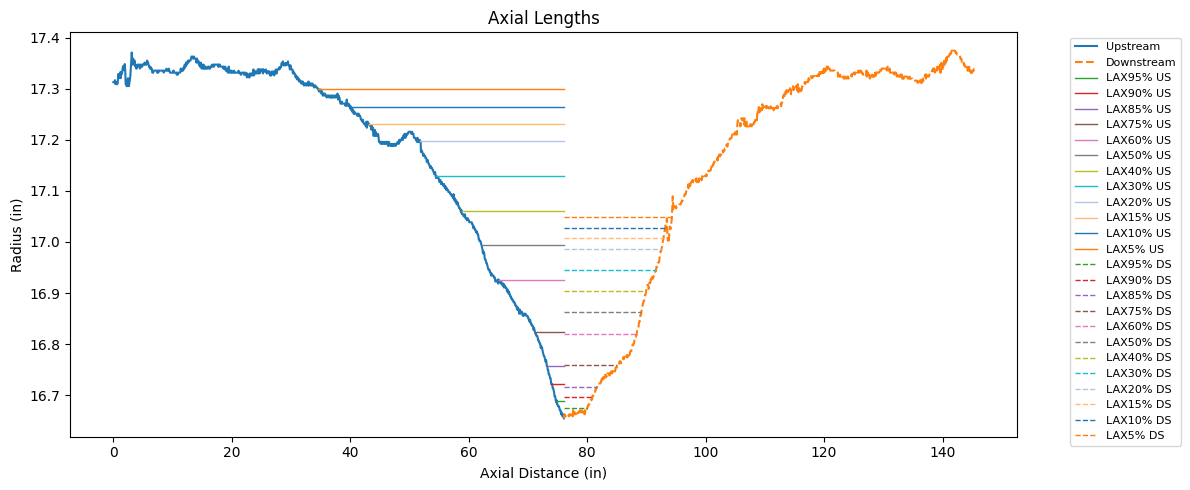

In [19]:
# Generate axial profile graph, for example
dp.graph("Axial")

## Step 2 - Perform Rainflow Cycle Counting
Create a `DentCycles` object using the `dd` dictionary, and then process the pressure history `df_p` with function `.process_liquid()`. Visit `cycle_counting` to see the capabilities of the module, but some quick attributes and functions are:
- Print the object (i.e., `print(DentCycles)`) to get a tabular summary of the key attributes, such as the `dd` dictionary and `Neq` values.
- Use the `.statistics` attribute to get the range pressure min/max/avg and mean pressure min/max/avg values.
- Use the `.cycles_binned` attribute to get the binning histogram as a dictionary with total cycles per bin. *Note: if no histogram binning is specified in `.process_liquid()`, then the default 28 bins from the MD-4-9 method will be used.*

In [20]:
# Create the DentCycles object
dc = cc.DentCycles(dd["OD"], dd["WT"], dd["SMYS"], dd["Lx"], dd["hx"], dd["SG"], dd["L1"], dd["L2"], dd["h1"], dd["h2"], dd["D1"], dd["D2"])
# Process the pressure history to get number of equivalent cycles at the dent location
Neq_SSI, Neq_CI, Neq_binned, cycles, cycles_binned = dc.process_liquid(
    [df_p[df_p.columns[0]].to_numpy(), df_p[df_p.columns[1]].to_numpy()], 
    df_p.index.to_numpy(dtype=np.datetime64)
    )

In [21]:
# Show summary of the DentCycles object
dc

DentCycles Object Summary:
                                   Parameter    Value                               Unit
                       Outside Diameter (OD)    12.75                                 in
                         Wall Thickness (WT)     0.25                                 in
     Specified Minimum Yield Strength (SMYS) 52000.00                                psi
                               Service Years     1.07                              years
                         S-N Curve Slope (M)     3.00                                  -
                      Minimum Pressure Range     5.00                               psig
             Location of Point Analysis (Lx)  1000.00                                 ft
            Elevation of Point Analysis (hx)    30.00                                 ft
                       Specific Gravity (SG)     0.80                                  -
 Location of Upstream Discharge Station (L1)   500.00                              

In [22]:
# Show statistics of the cycle counting results
dc.statistics

Rainflow Cycle Statistics:
                                  Parameter  Value                               Unit
                     Maximum Pressure Range 759.71                               psig
                     Minimum Pressure Range   5.00                               psig
                     Average Pressure Range  66.88                               psig
                      Maximum Pressure Mean 908.73                               psig
                      Minimum Pressure Mean 251.64                               psig
                      Average Pressure Mean 653.61                               psig
Neq using Spectrum Severity Indicator (SSI) 146.11    cycles/year (13ksi ref. stress)
                Neq using Cyclic Index (CI)   6.05 cycles/year (37.58ksi ref. stress)
                    Neq using Binned Cycles 462.23    cycles/year (13ksi ref. stress)


## Step 3 - Calculate Remaining Life
Use the `get_fatigue_life()` function from `md_fatigue` to determine the remaining life. This requires the `DentCycles` object, `DentProfiles` object, the `cycles` np.array containing the rainflow cycle count results, and a `curve_selection` dictionary.

The current supported S-N curves are: 
- ABS Guide for the Fatigue Assessment of Offshore Structure 2020, Table 1
- BS 7608:2014 Guide to fatigue design and assessment of steel products, Table 18
- DNV DNVGL-RP-C203 Fatigue design of offshore steel structures, Table 2-1

In [23]:
curve_selection = {"Category": "BS", 
                    "Curve": "D", 
                    "SD": 0}
calc_restraint, rp_results, fatigue_results  = mdf.get_fatigue_life(dc, dp, cycles, curve_selection)

In [24]:
# Show the calculated restraint
calc_restraint

'Unrestrained'

In [25]:
# Show the RP results
rp_results

{'US-CCW': np.float64(10.719144321360323),
 'US-CW': np.float64(9.482443804316196),
 'DS-CCW': np.float64(6.602330134049971),
 'DS-CW': np.float64(5.719040819377779)}

In [38]:
# Show the fatigue results
for lvl, value in fatigue_results.items():
    for sfbool, sfvalue in value.items():
        print(f"Level {lvl}, {sfbool}: {sfvalue:.3f} years")

Level 0, No SF: -0.737 years
Level 0, Yes SF: -0.147 years
Level 0.5, No SF: 3.113 years
Level 0.5, Yes SF: 0.468 years
Level 0.5+, No SF: 3.580 years
Level 0.5+, Yes SF: 0.405 years
Level 0.75, No SF: 2.588 years
Level 0.75, Yes SF: 0.330 years
Level 0.75+, No SF: 3.353 years
Level 0.75+, Yes SF: 0.377 years
